<a href="https://colab.research.google.com/github/shlear/MLDM-2022/blob/main/09-neural-networks/NNs_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from IPython.display import clear_output

# Task 1: maximum likelihood fit (3 points)

Let's generate a Gaussian mixture dataset and then fit its parameters with maximum likelihood.

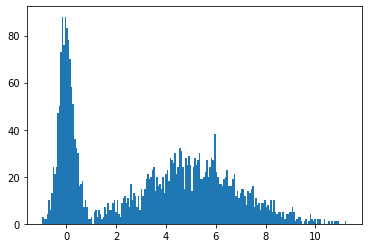

In [2]:
X1 = np.random.normal(size=1000, scale=0.3).astype('float32')
X2 = np.random.normal(size=2000, loc=5., scale=2.).astype('float32')

X = np.concatenate([X1, X2])
np.random.shuffle(X)

plt.hist(X, bins=200);

**Task**:
 - fill the gaps below to perform the max. likelihood fit with the pdf:
$$\text{PDF}(x|\mu_1, \sigma^2_1, \mu_2, \sigma^2_2, \alpha)
= \alpha\cdot\mathscr{N}(x|\mu_1, \sigma_1^2) + (1 - \alpha)\cdot\mathscr{N}(x|\mu_2, \sigma_2^2)$$
 - what the fitted values of $\mu_1, \sigma^2_1, \mu_2, \sigma^2_2$ and $\alpha$ should be? does your fit converge to them?

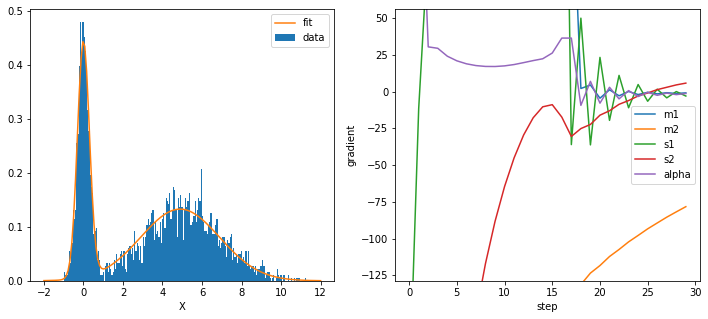

In [15]:


# Defining Gaussian PDF using torch functions
def gaussian(x, mu, sigma):
  x = torch.from_numpy(x)
  return 1 / (sigma * (torch.acos(torch.zeros(1)).item() * 4) ** 0.5) * torch.exp(- (x - mu) ** 2 / (2 * sigma ** 2)) # use torch.exp for the exponent, don't forget the normalization

# Arbitrary mixture PDF
def mixture(x, f1, f2, alpha):
  return alpha * f1(x) + (1. - alpha) * f2(x)

# Parameters that we'd like to infer (with an initial guess)
m1    = torch.tensor([1.0], requires_grad=True)
m2    = torch.tensor([4.0], requires_grad=True)
s1    = torch.tensor([1.0], requires_grad=True)
s2    = torch.tensor([1.0], requires_grad=True)
alpha = torch.tensor([0.5], requires_grad=True)

# At each gradient update we'll apply this function to
# ensure valid parameter values
def apply_constraints():
  # ensure the sigmas are positive (greater or equal to some small
  # positive number, e.g. 1e-5) and alpha is in (0, 1) interval
  # hint: use the `assign` method to update the variable values
  temp1, temp2 = [s1.data, s2.data]
  temp1, temp2 = [torch.clamp(temp1, min=1e-5), torch.clamp(temp2, min=1e-5)]
  s1.data, s2.data  = temp1, temp2
  temp_alpha = alpha.data
  temp_alpha = torch.clamp(temp_alpha, min=0, max=1)
  alpha.data = temp_alpha


variables = [m1, m2, s1, s2, alpha]

# Defining the overall PDF
def model_pdf(x):
  return mixture(x,
                 lambda t: gaussian(t, m1, s1),
                 lambda t: gaussian(t, m2, s2),
                 alpha)

# Log likelihood
def loglike(x):
  return -model_pdf(x).log().sum()

learning_rate = 0.0001
grad_history = [] # to keep track of gradient values at different steps
optim_gmm = torch.optim.SGD(variables, lr = learning_rate)

for i in range(30):
  # Forward pass:
  l = loglike(X)
  optim_gmm.zero_grad()
  # Backprop
  l.backward()
  # Gradient ascent step
  apply_constraints()
  grad_history.append([i.grad.detach().numpy()[0] for i in variables])
  optim_gmm.step()
  ############################
  # Do some plotting
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.hist(X, bins=200, density=True, label='data')
  x_grid = np.linspace(-2, 12, 150)
  plt.plot(x_grid, model_pdf(x_grid).detach(), label='fit')
  plt.legend()
  plt.xlabel('X')

  plt.subplot(1, 2, 2)
  lines = plt.plot(np.array(grad_history))
  low = min(grad_history[-1])
  high = max(grad_history[-1])
  plt.ylim(low  - (high - low) * 0.6,
         high + (high - low) * 0.6)
  plt.legend(lines, ['m1', 'm2', 's1', 's2', 'alpha'])
  plt.xlabel('step')
  plt.ylabel('gradient')
  plt.show()
  clear_output(wait=True);

# Task 2: classifying clothes (3 points)

In [16]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



[['Trouser' 'T-shirt/top' 'Trouser' 'Trouser' 'T-shirt/top' 'T-shirt/top'
  'Ankle boot' 'Sneaker']
 ['Pullover' 'Dress' 'Sneaker' 'Sandal' 'Shirt' 'Pullover' 'Sandal'
  'Sneaker']
 ['Dress' 'Shirt' 'T-shirt/top' 'Coat' 'Sneaker' 'Trouser' 'Sandal'
  'Ankle boot']
 ['Shirt' 'Sandal' 'Sandal' 'T-shirt/top' 'Coat' 'Ankle boot' 'Shirt'
  'Trouser']
 ['Pullover' 'T-shirt/top' 'Coat' 'T-shirt/top' 'Bag' 'Bag' 'Coat' 'Bag']
 ['Ankle boot' 'Trouser' 'Ankle boot' 'Pullover' 'Sandal' 'Shirt' 'Dress'
  'Bag']
 ['Bag' 'Ankle boot' 'Coat' 'Sandal' 'Bag' 'Ankle boot' 'Sneaker'
  'Pullover']
 ['Bag' 'Sandal' 'Sneaker' 'Sneaker' 'T-shirt/top' 'Dress' 'Shirt'
  'Sneaker']]


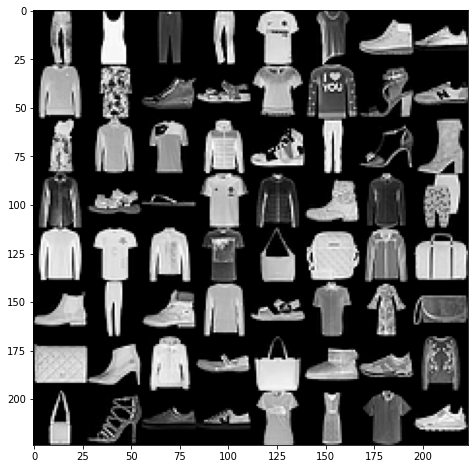

In [17]:
# Array for decoding the categories
label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])

# Get a single data batch of 64 images
sample_images, sample_labels = next(iter(trainloader))

# Plot the images in a 8x8 grid
plt.figure(figsize=(8, 8))
plt.imshow(
    sample_images.numpy().reshape(8, 8, 28, 28).transpose((0, 2, 1, 3)).reshape(224, 224),
    cmap='gray'
)
# Print corresponding labels
print(label_names[sample_labels.numpy().reshape(8, 8)])

**Task**:

Train a model which is an average of two models with different numbers of layers on the Fashion MNIST dataset, e.g.:

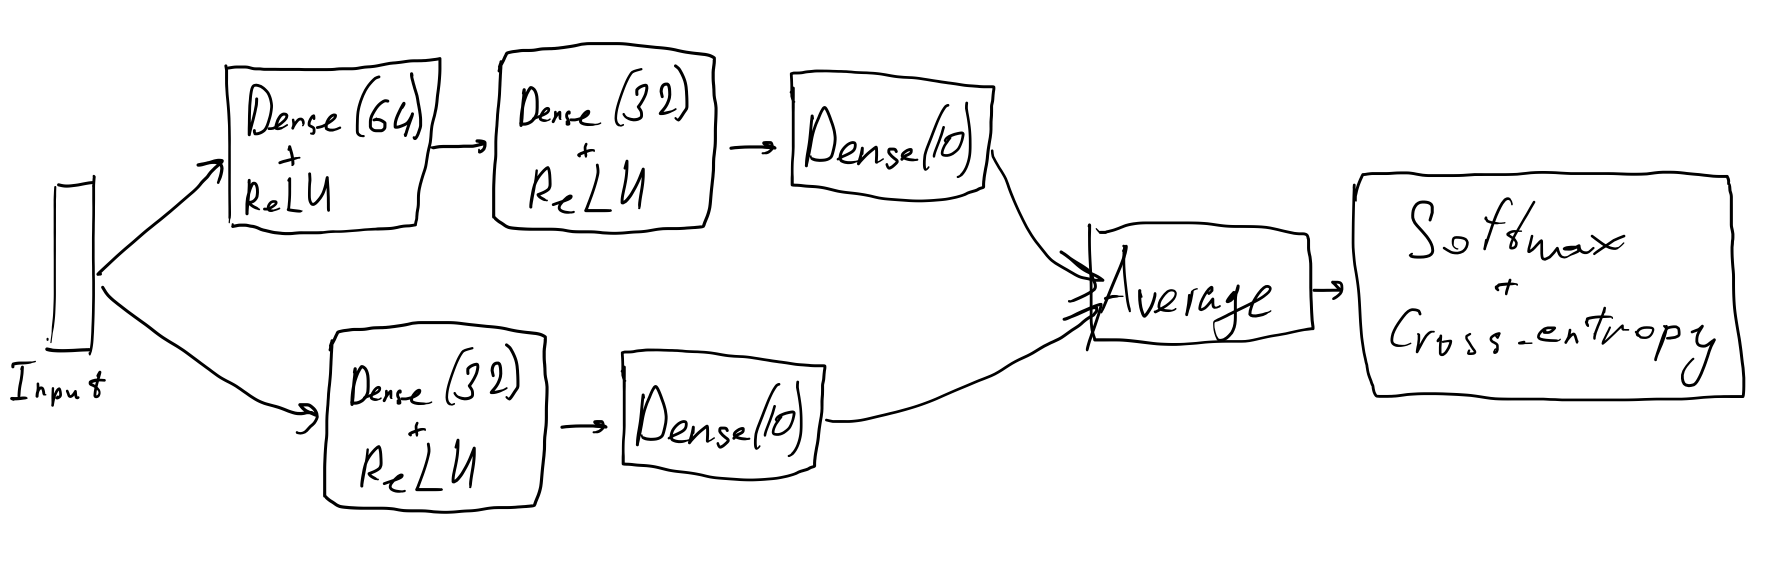

In [19]:
import torch.nn as nn

In [20]:
class FashionCNN_upper(nn.Module):
    def __init__(self):
        super(FashionCNN_upper, self).__init__()
        
        self.layer1 = nn.Sequential(nn.Linear(in_features=28*28, out_features=64),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(nn.Linear(in_features=64, out_features=32),
            nn.ReLU()
        )
        self.layer3 = nn.Linear(in_features=32, out_features=10)
    
    def forward(self, x):
        out = x.view(x.shape[0], -1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [21]:
class FashionCNN_down(nn.Module):
    def __init__(self):
        super(FashionCNN_down, self).__init__()
        
        self.layer1 = nn.Sequential(nn.Linear(in_features=28*28, out_features=32),
            nn.ReLU()
        )
        self.layer2 = nn.Linear(in_features=32, out_features=10)
    
    def forward(self, x):
        out = x.view(x.shape[0], -1)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

In [22]:
model_upper = FashionCNN_upper()
model_down = FashionCNN_down()

eriterion = nn.CrossEntropyLoss()
learning_rate = 0.01
epochs = 30
steps = 0

optimizer_upper = torch.optim.SGD(model_upper.parameters(), lr=learning_rate)
optimizer_down = torch.optim.SGD(model_upper.parameters(), lr=learning_rate)

In [23]:
model_upper.train()
train_losses= [] # just in case there would be some usage later
for itera in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer_upper.zero_grad()
        outputs = model_upper(images)
        loss = eriterion(outputs, labels)
        loss.backward()
        optimizer_upper.step()
        running_loss += loss.item() * images.size(0)
    
    running_loss = running_loss / len(trainloader.sampler)
    train_losses.append(running_loss)

torch.save(model_upper.state_dict(), "model_upper")

In [ ]:
model_down.train()
train_losses_down= []
for itera in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer_down.zero_grad()
        outputs = model_down(images)
        loss = eriterion(outputs, labels)
        loss.backward()
        optimizer_down.step()
        running_loss += loss.item() * images.size(0)
    
    running_loss = running_loss / len(trainloader.sampler)
    train_losses_down.append(running_loss)

torch.save(model_down.state_dict(), "model_down")

In [27]:
model_upper_load = FashionCNN_upper()
model_down_load = FashionCNN_down()
model_upper_load.load_state_dict(torch.load("m2"))
model_down_load.load_state_dict(torch.load("m1"))

FileNotFoundError: ignored

In [ ]:
class FashionCNN_ensemble(nn.Module):
    
    def __init__(self, modelA, modelB):
        super(FashionCNN_ensemble, self).__init__()
        
        self.modelA = modelA
        self.modelB = modelB

    def forward(self, x):
        out1 = self.modelA(x)
        out2 = self.modelB(x)
        out = (out1 + out2) / 2.
        return torch.softmax(out, dim=1)

In [ ]:
model_ensemble = FashionCNN_ensemble(model_upper_load, model_down_load)
optimizer_ensemble = torch.optim.SGD(model_ensemble.parameters(), lr=learning_rate)

In [ ]:
model_ensemble.train()
train_losses_ensemble= []
for itera in range(epochs):
    running_loss_ensemble = 0
    for images, labels in trainloader:
        optimizer_ensemble.zero_grad()
        outputs = model_ensemble(images)
        loss = eriterion(outputs, labels)
        loss.backward()
        optimizer_ensemble.step()
        running_loss_ensemble += loss.item() * images.size(0)
    
    running_loss_ensemble = running_loss_ensemble / len(trainloader.sampler)
    train_losses_ensemble.append(running_loss_ensemble)

torch.save(model_ensemble.state_dict(), "model_ensemble")

In [ ]:
plt.plot(train_losses_ensemble, label="Train loss")
plt.legend()
plt.show()

In [ ]:
test_loss = 0
class_correct = [0. for i in range(10)]
class_total = [0. for i in range(10)]

model_ensemble.eval()
for images, labels in testloader:
    outputs = model_ensemble(images)
    loss = eriterion(outputs, labels)
    test_loss += loss.item() * images.size(0)
    
    _, pred = torch.max(outputs, 1)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] +=1
        
test_loss = test_loss / len(testloader.sampler)
test_loss

In [ ]:
for i in range(10):
    print(class_correct[i] / class_total[i]) if class_total[i] > 0 else print("N/A training samples")

Accuracy

In [ ]:
np.sum(class_correct) / np.sum(class_total)